# Code Appendix

## Importing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import datetime

In [2]:
# import raw dataset with millions of rows
accepted_data_full = pd.read_csv('accepted_full.csv.gz', 
                   compression='gzip', low_memory=True)
rejected_data_full = pd.read_csv('rejected_full.csv.gz', 
                   compression='gzip', low_memory=True)

/Users/sarahpoisner/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('Accepted Dataset Info')
print('---------------------')
accepted_data_full.info()
print('\nRejected Dataset Info')
print('---------------------')
rejected_data_full.info()

Accepted Dataset Info
---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB

Rejected Dataset Info
---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


### Calculate Risk Scores
Check to see if FICO and Vantage risk score systems vary widely.

In [4]:
# check if risk score varies between FICO and Vantage
mask = rejected_data_full[rejected_data_full['Application Date'] \
                          < '2013-11-05']
mask2 = rejected_data_full[rejected_data_full['Application Date'] \
                           > '2013-11-05']
print(f'% with FICO: {100*(len(mask)/len(rejected_data_full))}%')
print(f'% with Vantage: {100*(len(mask2)/len(rejected_data_full))}%')

% with FICO: 5.070896356546578%
% with Vantage: 94.91591316942785%


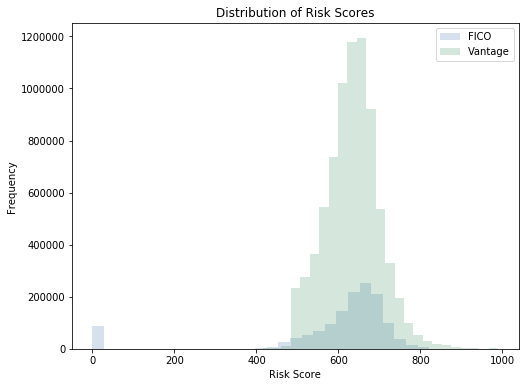

In [6]:
# plot distribution of risk scores
plt.figure(figsize=(8,6))
plt.hist(mask['Risk_Score'], bins=30, 
         color='lightsteelblue', label='FICO', alpha=0.5)
plt.hist(mask2['Risk_Score'], bins=30, 
         color='seagreen', label='Vantage', alpha=0.2)
plt.title('Distribution of Risk Scores') 
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Average the low and high FICO scores at loan origination to get the risk score for accepted loans.

In [7]:
low = accepted_data_full['fico_range_low']
high = accepted_data_full['fico_range_high']
accepted_data_full['risk_score'] = (low+high)/2

### Combine Datasets
I only kept columns that applied to both the 'accepted' and 'rejected' datasets, created binary variables for loan_accepted, and combined the two datasets.

In [9]:
accepted_data = accepted_data_full[['loan_amnt', 
                                    'title', 'dti', 'zip_code', 
                                    'emp_length', 
                                    'policy_code', 'risk_score']]
rejected_data = rejected_data_full[['Amount Requested', 
                                    'Loan Title', 'Debt-To-Income Ratio', 
                                    'Zip Code', 'Employment Length', 
                                    'Policy Code', 'Risk_Score']]

In [10]:
# assign binary classifications
accepted = np.ones((len(accepted_data), 1)) # accepted = 1
rejected = np.zeros((len(rejected_data), 1)) # rejected = 0

# append binary classifications to images
accepted_data_1 = np.append(accepted_data, accepted, axis=1)
rejected_data_0 = np.append(rejected_data, rejected, axis=1)

In [12]:
# combine accepted and rejected data into one dataset
all_data = np.concatenate((accepted_data_1, rejected_data_0))

# create dataframe
columns = ['loan_amnt', 'title', 'dti', 
           'zip_code', 'emp_length', 'policy_code', 
           'risk_score', 'loan_accepted']
df = pd.DataFrame(all_data, columns=columns)
df

,loan_amnt,title,dti,zip_code,emp_length,policy_code,risk_score,loan_accepted
0,3600,Debt consolidation,5.91,190xx,10+ years,1,677,1
1,24700,Business,16.06,577xx,10+ years,1,717,1
2,20000,NaN,10.78,605xx,10+ years,1,697,1
3,35000,Debt consolidation,17.06,076xx,10+ years,1,787,1
4,10400,Major purchase,25.37,174xx,3 years,1,697,1
...,...,...,...,...,...,...,...,...
29909437,10000,Debt consolidation,41.26%,441xx,< 1 year,0,590,0
29909438,10000,moving,1.48%,207xx,5 years,0,NaN,0
29909439,1200,Other,10.26%,914xx,< 1 year,0,686,0
29909440,25000,debt_consolidation,17.71%,880xx,< 1 year,0,NaN,0


## Data Cleaning
Here I cleaned the data set so it can be easily used in the models with numerical representation for all variables.

In [13]:
# print number of unique values in each column
print('Unique Values')
print('---------------------')
for col in df:
    print(col, ':', len(df[col].unique()))
    
# count NA values in each column
print('\nNA Values')
print('---------------------')
print(df.isna().sum())

Unique Values
---------------------
loan_amnt : 3641
title : 127127
dti : 136991
zip_code : 1002
emp_length : 12
policy_code : 4
risk_score : 694
loan_accepted : 2

NA Values
---------------------
loan_amnt              33
title               24661
dti                  1744
zip_code              327
emp_length        1098295
policy_code           951
risk_score       18497663
loan_accepted           0
dtype: int64


### Drop Null Values

In [14]:
# drop null values, we'll still have ~10,000,000 samples
df = df.dropna()
df.shape

(11085732, 8)

### Drop Policy Code

In [15]:
# view policy code frequencies
print('Policy Code Frequencies:')
df['policy_code'].value_counts()[0:25]

Policy Code Frequencies:


0.0    8977809
1.0    2093537
2.0      14386
Name: policy_code, dtype: int64

In [16]:
df = df.drop(columns=['policy_code'])
df.shape

(11085732, 7)

### Categorize Titles

In [17]:
# determine types of values for 'title'
sum_25 = sum(df['title'].value_counts()[0:25])
percent_25 = np.round((sum_25/len(df['title']))*100,2)
print(f'Number of Samples in Top 25 Titles:  {sum_25} ({percent_25}%)')
df['title'].value_counts()[0:25]

Number of Samples in Top 25 Titles:  10761277 (97.07%)


Debt consolidation         3470529
debt_consolidation         1754600
Credit card refinancing    1117254
Other                       946605
other                       547714
credit_card                 444257
Home improvement            330997
Car financing               320619
home_improvement            200555
Medical expenses            182395
Major purchase              169852
car                         164159
Moving and relocation       139914
small_business              132822
major_purchase              129980
Home buying                 126745
moving                      126643
Business                    119396
medical                     114570
Vacation                     66094
house                        54986
vacation                     48024
Debt Consolidation           20444
wedding                      17691
Green loan                   14432
Name: title, dtype: int64

As we can see, 98.74% of the samples include the top 25 most common titles, so we should include samples which have titles with the corresponding topics. These topics are: debt (0), credit card (1), car (2), home improvement (3), home buying (4), major purchase (5), medical (6), business (7), vacation (8), environmental (9), and other (10).

In [18]:
# categorize 'title' variables

# extract titles from 'title'
titles = list(df['title'])

new_titles = [0 for i in range(len(titles))]

for i in range(len(titles)):
    t = str(titles[i])
    if('debt' in t.lower()): 
        new_titles[i] = int(0) 
    elif('card' in t.lower()):
        new_titles[i] = int(1)
    elif('car' in t.lower()):
        new_titles[i] = int(2)
    elif('improvement' in t.lower()):
        new_titles[i] = int(3)
    elif('home buying' in t.lower() or \
         'house' in t.lower() or 'moving' in t.lower()):
        new_titles[i] = int(4)
    elif('major' in t.lower()):
        new_titles[i] = int(5)
    elif('medical' in t.lower()):
        new_titles[i] = int(6)
    elif('business' in t.lower()):
        new_titles[i] = int(7)
    elif('vacation' in t.lower()):
        new_titles[i] = int(8)
    elif('green' in t.lower() or 'energy' in t.lower()):
        new_titles[i] = int(9)
    elif('other' in t.lower()):
        new_titles[i] = int(10)
    else:
        new_titles[i] = np.nan

df['title'] = new_titles
df = df.dropna() # drop samples without title
df.shape

(10878960, 7)

### Reformat to Numerical Values

In [19]:
# re-format 'emp_length' to integers

# extract employment length from 'emp_length'
emp_lengths = list(df['emp_length'])

new_emp_lengths = [0 for i in range(len(emp_lengths))]

for i in range(len(emp_lengths)):
    l = str(emp_lengths[i])
    if(l[0]=='<'): # use 0.5 for less than 1 year
        new_emp_lengths[i] = float(0.5) 
    elif(l[0:1]=='10'):
        new_emp_lengths[i] = float(10)
    else:
        new_emp_lengths[i] = float(l[0])

df['emp_length'] = new_emp_lengths

In [20]:
# remove '%' sign from 'dti'

# extract dti from 'dti'
dtis = list(df['dti'])

new_dtis = [0 for i in range(len(dtis))]

for i in range(len(dtis)):
    dti = str(dtis[i])
    if(dti[-1]=='%'): 
        new_dtis[i] = float(dti[:-1])
    else:
        new_dtis[i] = float(dti)

df['dti'] = new_dtis

In [21]:
# remove 'xx' sign from 'zip_code'

# fix irregular value
df['zip_code'] = df['zip_code'].replace({'09Oxx':'090xx'})

# extract zip code from 'zip_code'
zip_codes = list(df['zip_code'])

new_zip_codes = [0 for i in range(len(zip_codes))]

for i in range(len(zip_codes)):
    code = str(zip_codes[i])
    new_zip_codes[i] = int(code[:-2])

df['zip_code'] = new_zip_codes

In [22]:
# fix data types for remaining variables
df['loan_amnt'] = df['loan_amnt'].astype(int)
df['loan_accepted'] = df['loan_accepted'].astype(int)
df['risk_score'] = df['risk_score'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10878960 entries, 0 to 29909441
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   loan_amnt      int64  
 1   title          float64
 2   dti            float64
 3   zip_code       int64  
 4   emp_length     float64
 5   risk_score     float64
 6   loan_accepted  int64  
dtypes: float64(4), int64(3)
memory usage: 664.0 MB


In [23]:
df

,loan_amnt,title,dti,zip_code,emp_length,risk_score,loan_accepted
0,3600,0.0,5.91,190,1.0,677.0,1
1,24700,7.0,16.06,577,1.0,717.0,1
3,35000,0.0,17.06,76,1.0,787.0,1
4,10400,5.0,25.37,174,3.0,697.0,1
5,11950,0.0,10.20,300,4.0,692.0,1
...,...,...,...,...,...,...,...
29909434,30000,0.0,55.15,726,0.5,681.0,0
29909435,1000,0.0,31.31,761,0.5,531.0,0
29909437,10000,0.0,41.26,441,0.5,590.0,0
29909439,1200,10.0,10.26,914,0.5,686.0,0


### Save Formatted Dataset
I saved the formatted dataset to a csv file to avoid running the formatting code each time.

In [24]:
# save formatted dataframe to csv file
df.to_csv('formatted_data.csv.zip', 
          compression={'method':'zip'})

In [25]:
# import formatted dataframe
df = pd.read_csv('formatted_data.csv.zip', 
                 compression='zip')
# drop index column
df = df[['loan_amnt', 'title', 'dti', 'zip_code', 
         'emp_length', 'risk_score', 'loan_accepted']]

## Splitting & Scaling

The dataset is split into training and testing sets and scaled. Scaling is sensitive to outliers, so outliers are removed from datasets.

### Removing Outliers

<Figure size 432x288 with 0 Axes>

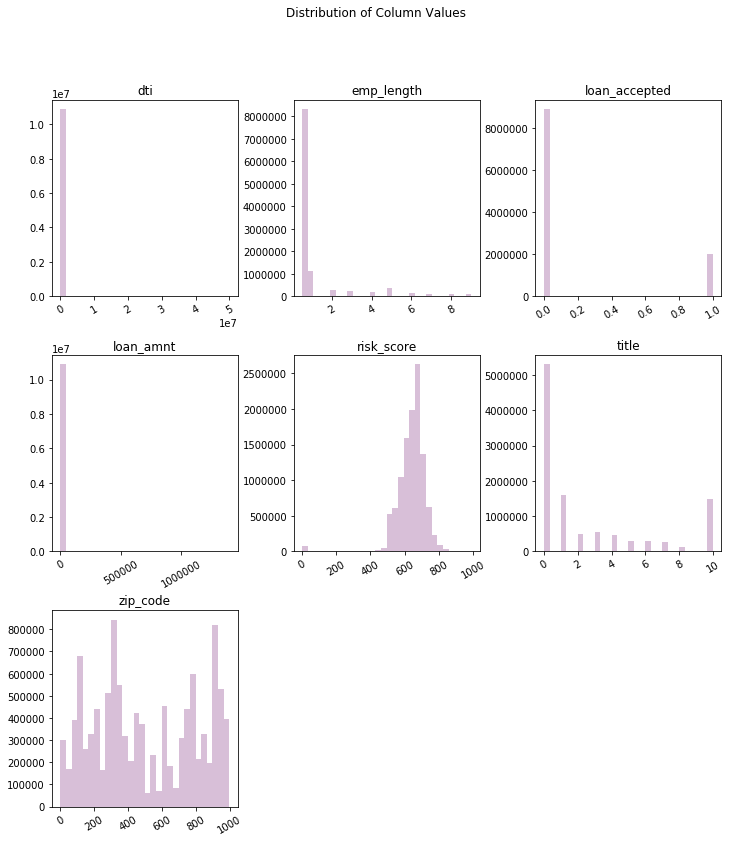

In [27]:
plt.figure()
df.hist(bins = 30, figsize = (12,13), 
        color = 'thistle', grid = False, xrot = 30)
plt.suptitle("Distribution of Column Values")
plt.show()

In [28]:
# reduce dti to 95% quantile
dti_05 = df['dti'].quantile(0.05)
dti_95 = df['dti'].quantile(0.95)
df = df[(df['dti'] > dti_05) & (df['dti'] < dti_95)]

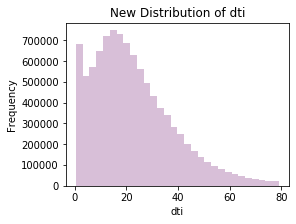

In [29]:
# plot new dti frequencies
plt.figure(figsize=(4,3))
plt.hist(df['dti'], bins=30, color='thistle')
plt.title('New Distribution of dti')
plt.xlabel('dti')
plt.ylabel('Frequency')
plt.show()

In [30]:
# reduce loan_amnt to 95% quantile
loan_amnt_05 = df['loan_amnt'].quantile(0.05)
loan_amnt_95 = df['loan_amnt'].quantile(0.95)
df = df[(df['loan_amnt'] > loan_amnt_05) & \
        (df['loan_amnt'] < loan_amnt_95)]

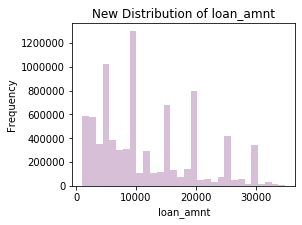

In [31]:
# plot new dti frequencies
plt.figure(figsize=(4,3))
plt.hist(df['loan_amnt'], bins=30, color='thistle')
plt.title('New Distribution of loan_amnt')
plt.xlabel('loan_amnt')
plt.ylabel('Frequency')
plt.show()

In [32]:
df.shape

(8471377, 7)

### Evenly Distribute loan_accepted

In [33]:
# separate dataframe by 'loan_accepted' status
df_accepted = df.loc[df['loan_accepted'] == 1]
df_rejected = df.loc[df['loan_accepted'] == 0]

# randomly sample from accepted loans
size = len(df_accepted)
df_rejected_new = df_rejected.sample(n=size,replace=False)

# concat remaining accepted samples with rejected samples
df2 = pd.concat([df_accepted, df_rejected_new])

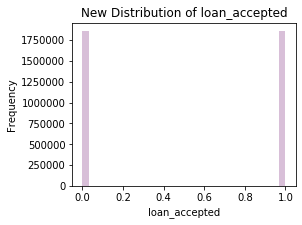

In [34]:
# plot new loan_accepted frequencies
plt.figure(figsize=(4,3))
plt.hist(df2['loan_accepted'], bins=30, color='thistle')
plt.title('New Distribution of loan_accepted')
plt.xlabel('loan_accepted')
plt.ylabel('Frequency')
plt.show()

In [35]:
df2.shape

(3726470, 7)

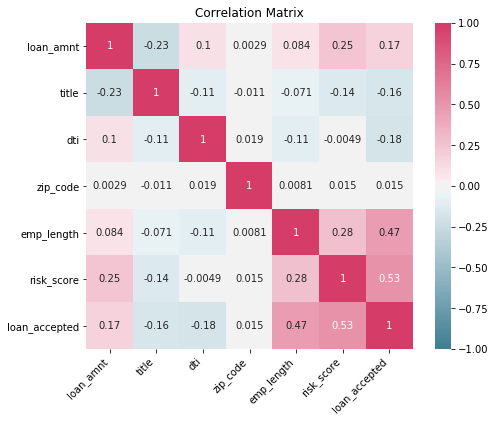

In [36]:
# plot heatmap to show correlation between variables
plt.figure(figsize=(8,6))

ax = sns.heatmap(df2.corr(), 
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(220, 1, n=200),
                 square=True, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

plt.title('Correlation Matrix')
plt.show()

### Split & Scale Data

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [127]:
# define variables

# use all but 'loan_accepted' as independent variables
X = df2.drop('loan_accepted', axis=1)

# use 'loan_accepted' as dependent variable
y = df2['loan_accepted']

# split data into train and test sets
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=0)

# scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model & Results

Define a logistic regression model to predict whether a loan would be accepted or rejected using data.



In [534]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, plot_confusion_matrix, \
accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score

### Grid-Search Cross-Validation

In [58]:
%%time
# create the hyperparameter grid
param_grid = {'C' : [0.1,1,10], 
              'solver' : ['lbfgs', 'sag', 'saga'], 
              'tol' : [0.0001, 0.001, 0.01, 0.1]}

# create logistic regression classifier
logregs = LogisticRegression()

# define GridSearchCV object
logreg_cv = GridSearchCV(logregs, param_grid, cv=5)

# fit GridSearchCV object to training data
logreg_cv.fit(X_train, y_train)

print('Cross-Validation Complete')

Cross-Validation Complete
CPU times: user 32min 1s, sys: 2min 21s, total: 34min 23s
Wall time: 23min 45s


In [59]:
# print best parameters and best score
print(f'Tuned Log-Reg Parameters: {logreg_cv.best_params_}')
print(f'Tuned Log-Reg Accuracy: {logreg_cv.best_score_}')

Tuned Log-Reg Parameters: {'C': 10, 'solver': 'saga', 'tol': 0.01}
Tuned Log-Reg Accuracy: 0.8364011362090699


### Logistic Regression

In [128]:
# create the classifier
logreg = LogisticRegression(C=10, solver='saga', tol=0.01)

# fit the classifier to the training data
logreg.fit(X_train,y_train)

# predict the labels of the test set
y_pred = logreg.predict(X_test)

In [583]:
# print coeffients
print('Model Coefficients:')
logreg.coef_

Model Coefficients:


array([[ 0.3670628 , -1.11940209, -3.40152447,  0.11981281,  5.47288097,
        28.45368496]])

In [129]:
# compute and print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))
print(f'Accuracy Score (Train): {logreg.score(X_train, y_train)}')
print(f'Accuracy Score (Test): {logreg.score(X_test, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84    372808
           1       0.82      0.86      0.84    372486

    accuracy                           0.84    745294
   macro avg       0.84      0.84      0.84    745294
weighted avg       0.84      0.84      0.84    745294

Accuracy Score (Train): 0.8387981789736668
Accuracy Score (Test): 0.8387052626211938


<Figure size 432x288 with 0 Axes>

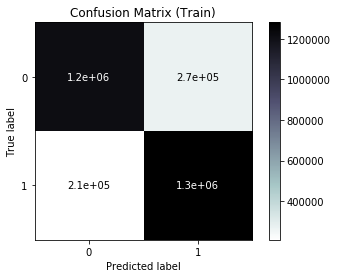

<Figure size 432x288 with 0 Axes>

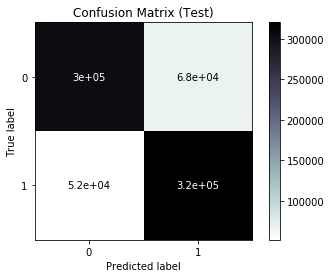

In [150]:
# plot confusion matrices

# train data
plt.figure()
plot_confusion_matrix(logreg, X_train, y_train, cmap=plt.cm.bone_r)
plt.title('Confusion Matrix (Train)')
plt.show()

# test data
plt.figure()
plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.bone_r)
plt.title('Confusion Matrix (Test)')
plt.show()

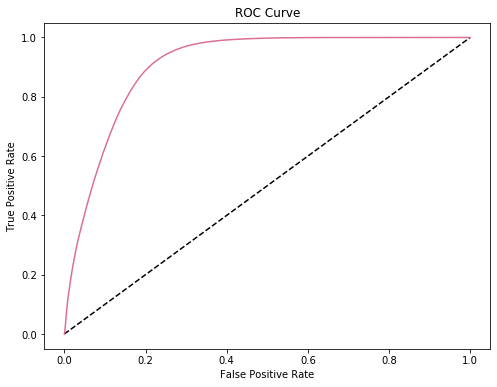

In [533]:
# plot ROC curve

# calculate predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# plot ROC curve
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color='palevioletred')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [538]:
# calculate AUC score

auc = roc_auc_score(y_test, y_pred_prob)

print(f'AUC: {np.round(auc,3)}')

# calculate Cross-Validated AUC score
cv_auc = cross_val_score(logreg, X, y, 
                         cv=5, scoring='roc_auc')

print(f'Cross-Validated AUC: {np.round(cv_auc,3)}')

AUC: 0.908
Cross-Validated AUC: [0.769 0.755 0.77  0.77  0.771]


In [540]:
print(f'Cross-Validated AUC: {np.mean(cv_auc)}')

Cross-Validated AUC: 0.7670535654128972


## Predicting Loan Limits
Predict the maximum loan an applicant should apply for where is expected to be approved.
### Define Predicting Function

In [579]:
def predict(user):
    '''
    Given a user's data, this function calculates
    the highest loan amount the user can apply 
    for where it is expected to be approved.
    Predictions are made using a pre-defined 
    logistic regression classifier.
    '''
    
    # drop 'loan_accepted' and show user data
    user_copy = user.copy().drop(columns=['loan_accepted'])
    display(user_copy)

    amounts = []
    predictions = []
    
    # make predictions for whether user is 
    # accepted or rejected for different loan amounts
    for i in range(500,40000,500):
        user_copy['loan_amnt'] = i
        user_scaled = scaler.transform(user_copy)
        
        prediction = logreg.predict(user_scaled)
        
        predictions.append(prediction)       
        amounts.append(i)
    
    # record results
    predictions = list(np.concatenate(predictions, axis=0))
    pred = [i for i in zip(predictions, amounts)]
    rejected = [i[1] for i in pred if i[0] == 0]
    accepted = [i[1] for i in pred if i[0] == 1]
    
    # calculate min/max loan amount using results
    if len(rejected)>0:
        if(rejected[0]==min(amounts)):
            if len(accepted)>0:
                print(f'Minimum Loan: ${max(rejected)}')
                vline = max(rejected)
            else:
                print(f'Loan Not Available')
                vline = 0
        else:
            print(f'Minimum Loan: ${max(rejected)}')
            vline = max(rejected)
    else: 
        print('No Maximum/Minimum')
        vline = 0    
    
    
    # plot results
    plt.figure(figsize=(6,4)) 
    plt.plot(amounts, predictions, color='olivedrab')
    
    # plot vline if there is a min/max loan amount
    if vline > 0:
        plt.vlines(vline, ymin=0, ymax=1, 
                   color='lightcoral', linestyles='dashed')
        
    plt.title('Predictions for User')
    plt.xlabel('Loan Amount')
    plt.ylabel('Accepted (1) or Rejected (0)')
    plt.show()


### Test Predicting Function

,loan_amnt,title,dti,zip_code,emp_length,risk_score
676542,7000,0.0,15.67,480,1.0,727.0


No Maximum/Minimum


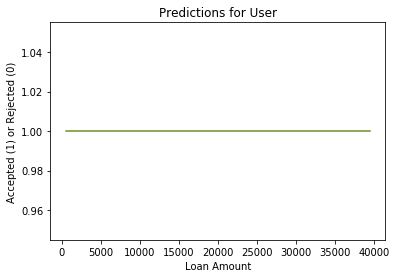

In [576]:
user_1 = df2.sample(n=1,random_state=0)
predict(user_1)

,loan_amnt,title,dti,zip_code,emp_length,risk_score
7679650,5000,0.0,54.14,840,0.5,554.0


Loan Not Available


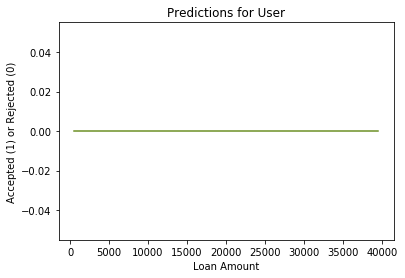

In [577]:
user_2 = df2.sample(n=1,random_state=1)
predict(user_2)

,loan_amnt,title,dti,zip_code,emp_length,risk_score
7178966,18000,0.0,18.5,60,0.5,683.0


Minimum Loan: $10000


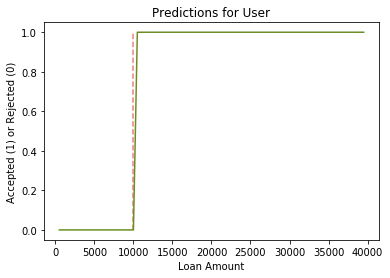

In [580]:
user_3 = df2.sample(n=1,random_state=15)
predict(user_3)

,loan_amnt,title,dti,zip_code,emp_length,risk_score
913297,9800,0.0,29.51,750,4.0,662.0


No Maximum/Minimum


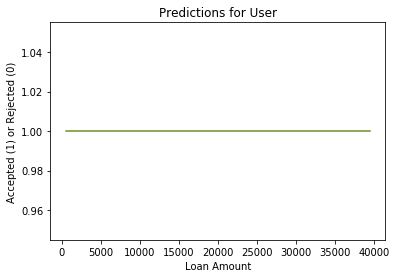

,loan_amnt,title,dti,zip_code,emp_length,risk_score
10517390,11000,0.0,71.53,296,0.5,705.0


Loan Not Available


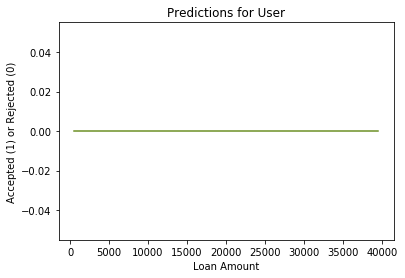

,loan_amnt,title,dti,zip_code,emp_length,risk_score
3597071,5000,1.0,43.16,841,0.5,677.0


Loan Not Available


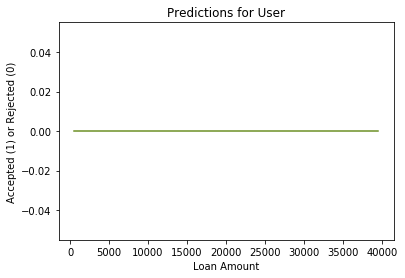

,loan_amnt,title,dti,zip_code,emp_length,risk_score
10122764,6000,6.0,3.07,33,0.5,684.0


Minimum Loan: $8000


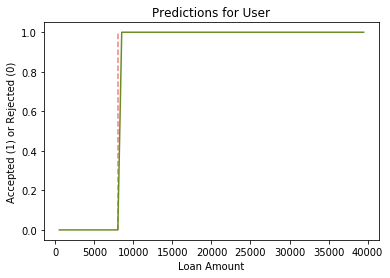

,loan_amnt,title,dti,zip_code,emp_length,risk_score
9666885,7000,1.0,34.43,70,1.0,667.0


Loan Not Available


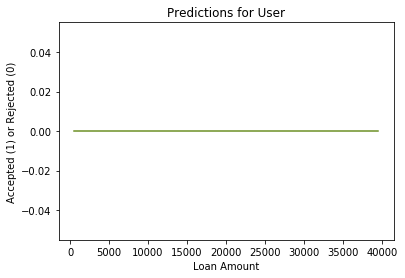

In [581]:
# run more tests
for i in range(5): 
    predict(df2.sample(n=1))